In [1]:
from google.colab import files
files.upload()  # ⬅️ Run this and upload kaggle.json when the window pops up.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keerthanadinesh1995","key":"d8e844b026d3052f953e46956ce36c47"}'}

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [17]:
!kaggle competitions download -c dogs-vs-cats


dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
import zipfile

with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dogs-vs-cats')


In [19]:
import zipfile

# Path to your ZIP file
zip_path = '/content/dogs-vs-cats.zip'
extract_path = '/content/dogs-vs-cats'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")


Unzipping completed!


In [20]:
import os

# Listing the contents
print(os.listdir('/content/dogs-vs-cats'))


['sampleSubmission.csv', 'train', 'test1.zip', 'train.zip', 'test1']


In [21]:
import zipfile

train_zip_path = '/content/dogs-vs-cats/train.zip'
train_extract_path = '/content/dogs-vs-cats/train'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)

print("Train data extracted successfully!")


Train data extracted successfully!


In [22]:
test_zip_path = '/content/dogs-vs-cats/test1.zip'
test_extract_path = '/content/dogs-vs-cats/test1'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print("Test data extracted successfully!")


Test data extracted successfully!


In [23]:
import os

print("Train files:", len(os.listdir('/content/dogs-vs-cats/train')))
print("Test files:", len(os.listdir('/content/dogs-vs-cats/test1')))


Train files: 1
Test files: 1


In [24]:
import zipfile

# Extract train.zip
with zipfile.ZipFile('/content/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dogs-vs-cats/train/train')

# Extract test1.zip
with zipfile.ZipFile('/content/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dogs-vs-cats/test1/test1')

# Check counts
import os

print("Train files:", len(os.listdir('/content/dogs-vs-cats/train/train')))
print("Test files:", len(os.listdir('/content/dogs-vs-cats/test1/test1')))


Train files: 25001
Test files: 12501


In [28]:
train_dir = '/content/dogs-vs-cats/train/train'
test_dir = '/content/dogs-vs-cats/test1/test1'

# Filter only jpg files
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

print("Filtered Train Images:", len(train_images))
print("Filtered Test Images:", len(test_images))


Filtered Train Images: 25000
Filtered Test Images: 12500


In [29]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import hog

# Paths
train_dir = '/content/dogs-vs-cats/train/train'

# List images
all_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
print(f"Total images found: {len(all_images)}")

# Limit to 5000 images for faster training
selected_images = all_images[:5000]

# Prepare data
X = []
y = []

print("Extracting HOG features...")

for img_name in selected_images:
    img_path = os.path.join(train_dir, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))

    # Corrected HOG Feature extraction
    features, _ = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=None  # Corrected argument for newer skimage
    )
    X.append(features)

    # Label extraction
    label = 1 if 'dog' in img_name else 0
    y.append(label)

X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)

print("Training SVM with GridSearch...")
grid.fit(X_train, y_train)

print(f"\nBest parameters: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_:.4f}")

# Predict & Evaluate
y_pred = grid.predict(X_test)
print("\nFinal Accuracy on Test Data:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Total images found: 25000
Extracting HOG features...
Training SVM with GridSearch...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7300

Final Accuracy on Test Data: 0.734

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       483
           1       0.75      0.72      0.74       517

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



In [30]:
import joblib

# Save the trained GridSearchCV model
joblib.dump(grid, '/content/svm_dog_cat_classifier_grid.pkl')

print("✅ Model saved successfully as 'svm_dog_cat_classifier_grid.pkl'")


✅ Model saved successfully as 'svm_dog_cat_classifier_grid.pkl'


In [31]:
# Load saved model
grid_loaded = joblib.load('/content/svm_dog_cat_classifier_grid.pkl')

# Use for prediction
y_pred = grid_loaded.predict(X_test)


In [32]:
from sklearn.metrics import classification_report

# Generate the report
report = classification_report(y_test, y_pred)

# Save it to a text file
with open('/content/svm_classification_report.txt', 'w') as f:
    f.write("Dog vs Cat Classification Report\n")
    f.write(report)

print("✅ Classification report saved as 'svm_classification_report.txt'")


✅ Classification report saved as 'svm_classification_report.txt'


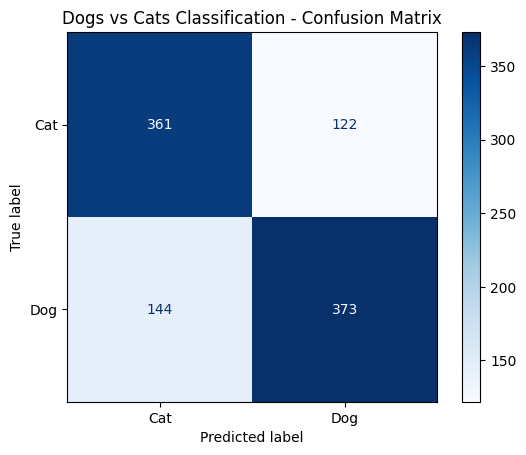

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Predict using your test data
y_pred = grid.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])

# Plot and save
disp.plot(cmap=plt.cm.Blues)
plt.title('Dogs vs Cats Classification - Confusion Matrix')
plt.savefig('/content/confusion_matrix.png')
plt.show()


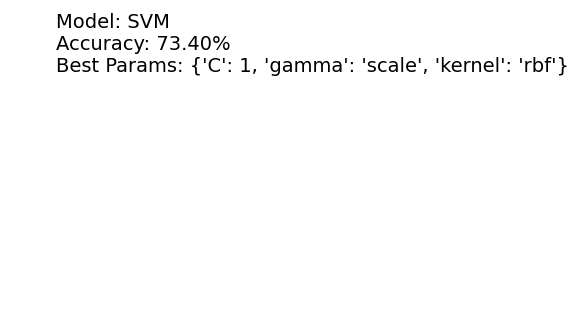

In [35]:
plt.figure(figsize=(6,4))
plt.text(0.1, 0.8, f"Model: SVM\nAccuracy: {accuracy_score(y_test, y_pred):.2%}\nBest Params: {grid.best_params_}",
         fontsize=14, color='black')
plt.axis('off')
plt.savefig('/content/model_summary.png')
plt.show()


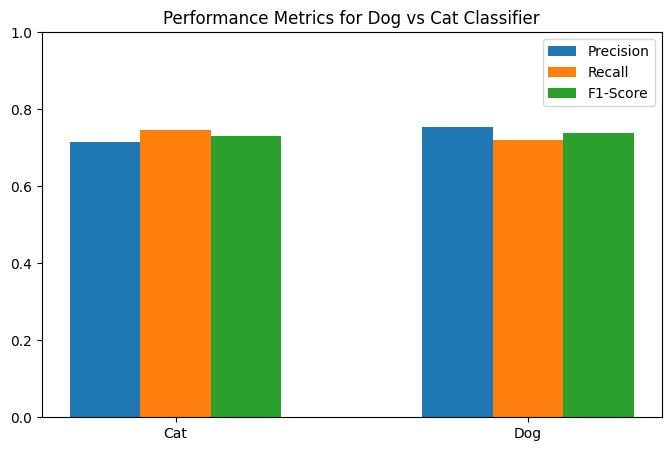

In [36]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Generate report dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract values for plotting
labels = ['Cat', 'Dog']
precision = [report['0']['precision'], report['1']['precision']]
recall = [report['0']['recall'], report['1']['recall']]
f1 = [report['0']['f1-score'], report['1']['f1-score']]

x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], f1, width=0.2, label='F1-Score', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.ylim(0,1)
plt.title('Performance Metrics for Dog vs Cat Classifier')
plt.legend()
plt.savefig('/content/performance_metrics.png')
plt.show()
